In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image

In [2]:
testpath= "/content/drive/MyDrive/E-Waste Classification Dataset/test"
trainpath= "/content/drive/MyDrive/E-Waste Classification Dataset/train"
validpath = "/content/drive/MyDrive/E-Waste Classification Dataset/val"

# **EDA**

In [3]:
print(f"Attempting to access directory: {trainpath}")
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Attempting to access directory: /content/drive/MyDrive/E-Waste Classification Dataset/train
Found 2400 files belonging to 10 classes.


In [4]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [5]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (224,224), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [6]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


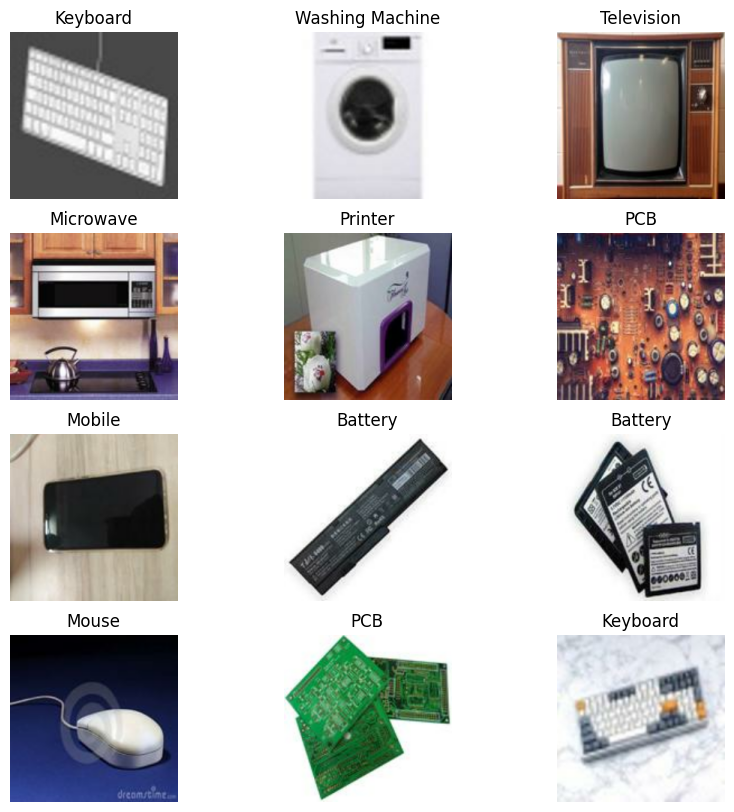

In [7]:
plt.figure(figsize=(10, 10))

for images, labels in datatrain.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

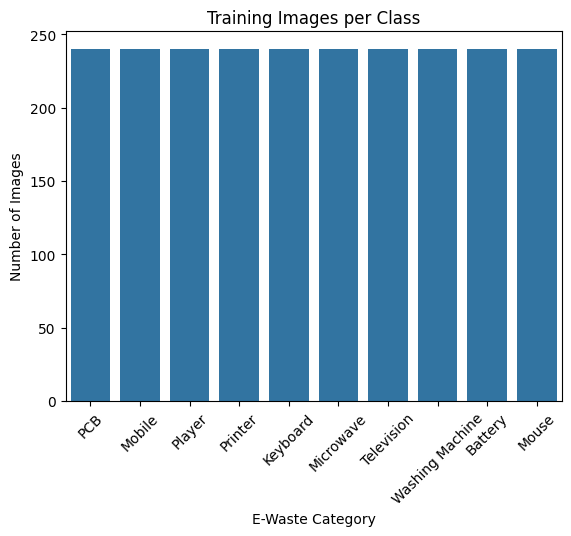

In [8]:
import os

classes = os.listdir(trainpath)
class_counts = {cls: len(os.listdir(os.path.join(trainpath, cls))) for cls in classes}

sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Training Images per Class")
plt.xlabel("E-Waste Category")
plt.ylabel("Number of Images")
plt.show()

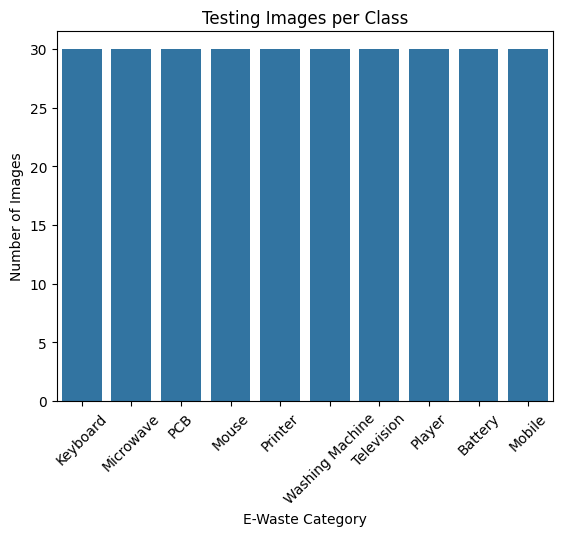

In [9]:
classes = os.listdir(testpath)
class_counts = {cls: len(os.listdir(os.path.join(testpath, cls))) for cls in classes}

sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Testing Images per Class")
plt.xlabel("E-Waste Category")
plt.ylabel("Number of Images")
plt.show()

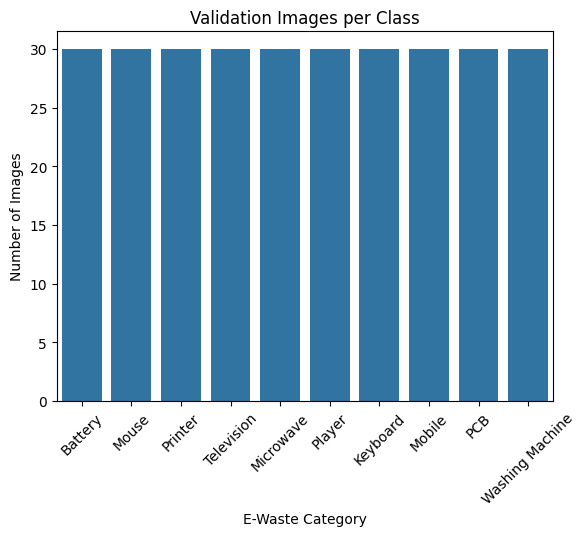

In [10]:
classes = os.listdir(validpath)
class_counts = {cls: len(os.listdir(os.path.join(validpath, cls))) for cls in classes}

sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Validation Images per Class")
plt.xlabel("E-Waste Category")
plt.ylabel("Number of Images")
plt.show()

## **Data Preprocessing**

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomBrightness(factor=0.15),
])

# **Model Selection**

In [12]:
base_model = tf.keras.applications.EfficientNetV2B3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:150]:
    layer.trainable = False

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# **Model Training and Tuning & Optimization**

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['Accuracy'])

In [14]:
# Implement ReduceLROnPlateau learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001
)

In [15]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [16]:
# Define the list of callbacks for training
callbacks_list = [early, lr_scheduler]

In [17]:
# Set the number of epochs to train the model
epochs = 15
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=epochs,
    callbacks=callbacks_list
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 919s 11s/step - Accuracy: 0.3069 - loss: 2.2812 - val_Accuracy: 0.9000 - val_loss: 1.0005 - learning_rate: 1.0000e-04
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 79s 318ms/step - Accuracy: 0.7755 - loss: 0.6643 - val_Accuracy: 0.9467 - val_loss: 0.4269 - learning_rate: 1.0000e-04
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - Accuracy: 0.8593 - loss: 0.4362 - val_Accuracy: 0.9567 - val_loss: 0.2010 - learning_rate: 1.0000e-04
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 25s 333ms/step - Accuracy: 0.9021 - loss: 0.3108 - val_Accuracy: 0.9667 - val_loss: 0.1250 - learning_rate: 1.0000e-04
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 310ms/step - Accuracy: 0.9214 - loss: 0.2359 - val_Accuracy: 0.9667 - val_loss: 0.0961 - learning_rate: 1.0000e-04
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - Accuracy: 0.9384 - loss: 0.1925 - val_Accuracy: 0.9733 - val_loss: 0.0892 - learning_rate: 1.0000e-04
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 316ms/step - Accu

## **Model Architecture**

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 7, 7, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,537,650 (135.57 MB)

 Trainable params: 11,292,756 (43.08 MB)

 Non-trainable params: 1,659,380 (6.33 MB)

 Optimizer params: 22,585,514 (86.16 MB)

In [19]:
base_model.summary()

Model: "efficientnetv2-b3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 11,274,314 (43.01 MB)

 Non-trainable params: 1,656,308 (6.32 MB)

# **Model Performance Visualization: Accuracy & Loss Trends**

In [20]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

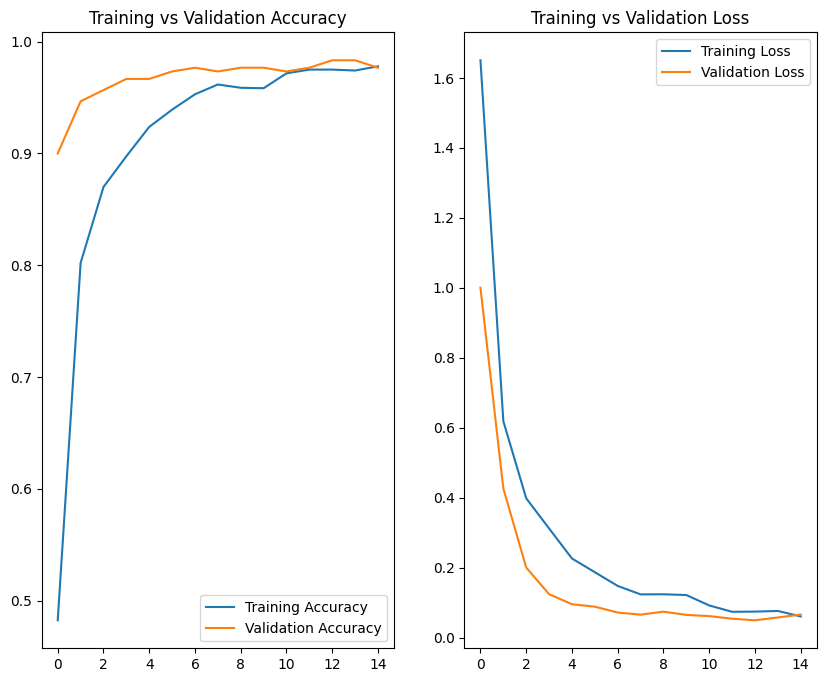

In [21]:
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()

# **Model Evaluation**

In [22]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is {accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 11s/step - Accuracy: 0.9712 - loss: 0.1026
Test accuracy is 0.9733, Test loss is 0.0890


In [23]:
### Evaluate Model Performance on Test Data using Classification Report

y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       1.00      1.00      1.00        30
           2       0.94      0.97      0.95        30
           3       1.00      1.00      1.00        30
           4       0.97      1.00      0.98        30
           5       0.97      0.97      0.97        30
           6       0.97      1.00      0.98        30
           7       0.91      1.00      0.95        30
           8       1.00      0.87      0.93        30
           9       1.00      1.00      1.00        30

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



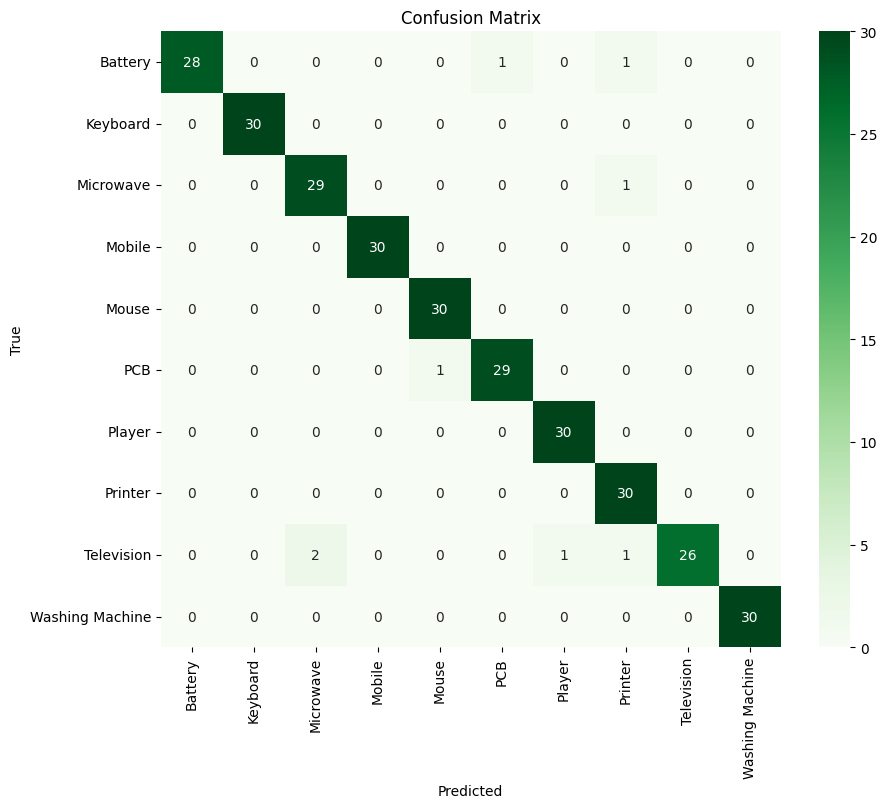

In [24]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Greens')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# **Final Testing and Save the Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


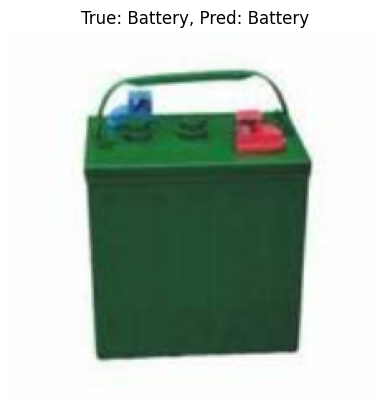

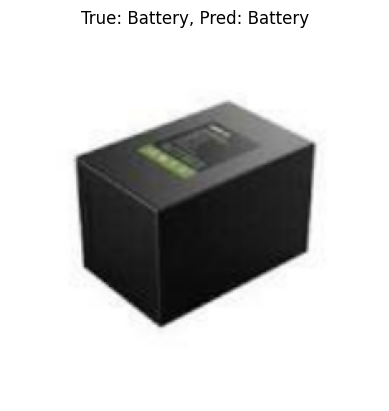

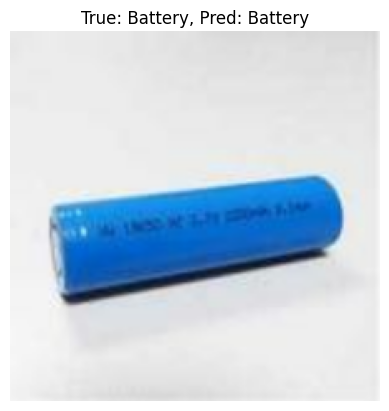

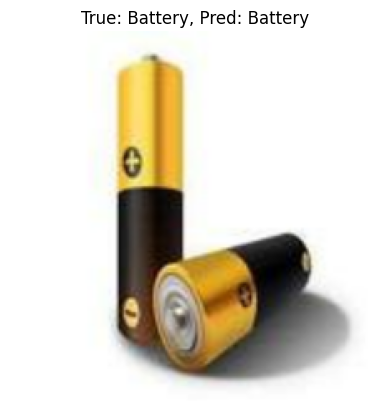

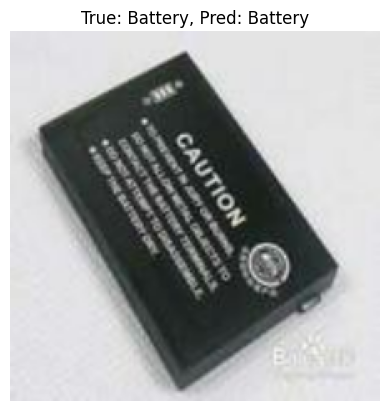

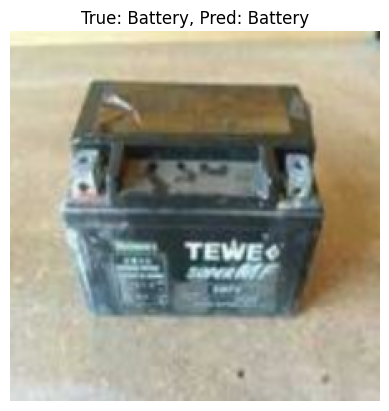

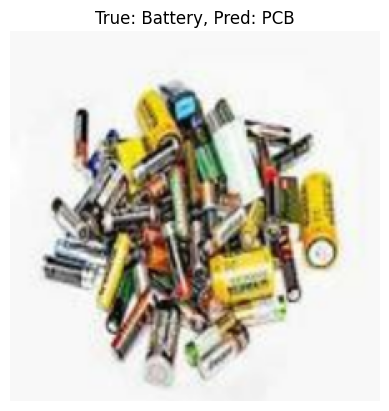

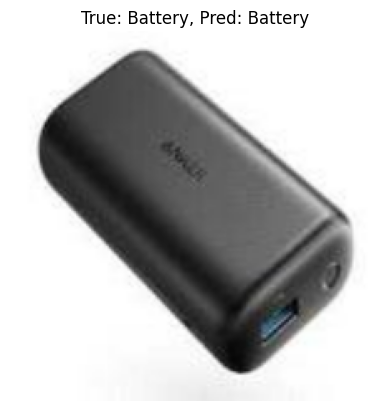

In [25]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names

for images, labels in datatest.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()

In [26]:
model.save('Efficient_classify.keras')

In [27]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

# **Model Deployment**

In [32]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((224, 224))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)[0]

    # Step 4: Return probabilities as a dictionary
    return {class_names[i]: float(prediction[i]) for i in range(len(class_names))}

In [33]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=10)
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ba3c099e5bb533e89b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
